In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import glob
import sys
import copy
import cv2
from imp import reload

In [2]:
dataDIR = '/mnt/ssd1/Documents/Vivek/locustVR/databases/data_collection/'
projectDB = '/mnt/ssd1/Documents/Vivek/locustVR/databases/locustProjects_20_01_07.db'
expDB = '/mnt/ssd1/Documents/Vivek/locustVR/databases/locustExperiments_20_01_07.db'

In [3]:
nPosts = 2

In [4]:
def rotate(xy, radians):
    x, y = xy
    c, s = np.cos(radians), np.sin(radians)
    j = np.matrix([[c, s], [-s, c]])
    m = np.dot(j, [x, y])

    return m

In [5]:
# establish a connecttion to the project database
conn = sqlite3.connect(projectDB)
# connect a cursor that goes through the project database
cursorProject = conn.cursor()
# establish a second connecttion to the experiment database
conn2 = sqlite3.connect(expDB)
# connect a cursor that goes through the experiment database
cursorExperiment = conn2.cursor()

# pick experiments from specified project
cursorExperiment.execute("Select expId from experiments where project = ? and exp >= ? and exp < ?",('DecisionGeometry', (nPosts-2)*10, (nPosts-1)*10))
fetched = cursorExperiment.fetchall()
print('fetched : ' + str(fetched))

fetched : [('c0127c9b-3ff9-4c49-8db4-6900ff4c2b2a',), ('54a35a9f-9eb0-4404-bc9d-8ed7b71192c5',), ('7ac51c48-5f5a-4ac3-9930-56772578c1ee',), ('3a1d5deb-e8f7-48a4-aabb-25456f941c43',), ('752b3218-e802-47e8-bbc6-1049f15e6f85',), ('13e69b2f-9760-4625-a309-511af2c5afb2',), ('2a7c4e5b-deb9-4c55-b0f7-2547034b8b4d',), ('da620536-7437-4bf6-a7de-ba36f19b4177',), ('acb6ec35-e1e0-450a-98ca-581b0f21723e',), ('1730f55c-ba6b-467b-96a8-f23c387f2905',), ('a57b486a-c26a-4016-9722-56846965487e',), ('ded361ec-3214-458a-858f-1be11809fd14',), ('8f13a403-e1bd-4adf-9a4a-ef18b2e4915e',), ('8e0cb790-55be-46b5-be17-f92c2208f12d',), ('5cb7d44f-5166-46ce-b317-f4bd8d3267c5',), ('9e41ebbd-fadd-4ea5-8457-77c541faa137',), ('e62178c9-e0f0-4970-82b6-e26225576f3b',), ('19c69caf-3dc5-4cf4-950c-95acad45ecd9',), ('a678f783-103d-4485-a995-78d7f6b9824e',), ('43f0818a-bae1-44ca-bef9-8823bb8c8ab9',), ('5e103a3b-105b-4820-92e1-b2c2cf2c11ee',), ('2292bbb7-d520-4715-a948-dbd7422e6660',), ('125adcc5-4f9b-47ba-9849-53aa901c5442',), 

In [6]:
angles = []
dataDict0 = []
dataDict1 = []
rot_post0 = []
for uuid in range(0,len(fetched)):
    cursorExperiment.execute("Select exp from experiments where expId = ?", (fetched[uuid][0],))
    fetch_exp = cursorExperiment.fetchall()[0][0]
    cursorExperiment.execute("Select replicate from experiments where expId = ?", (fetched[uuid][0],))
    fetch_rep = cursorExperiment.fetchall()[0][0]

    cursorProject.execute("Select post0 from projects where project = ? and exp = ? and replicate = ?",('DecisionGeometry', fetch_exp, fetch_rep))
    dataDict0.append(cursorProject.fetchall())
    cursorProject.execute("Select post1 from projects where project = ? and exp = ? and replicate = ?",('DecisionGeometry', fetch_exp, fetch_rep))
    dataDict1.append(cursorProject.fetchall())

    tmp = pd.read_csv(dataDIR + fetched[uuid][0] + "/results.csv", names = ["x", "y", "z", "event", "t", "nStimuli"])
    tmp['uuid'] = uuid
    tmp['angle'] = np.nan
    tmp['post0_x'] = tmp['post0_y'] = tmp['post1_x'] = tmp['post1_y'] = np.nan
    
    for a in range(1,4):
        tmp.loc[tmp['nStimuli'] == a, 'angle'] = eval(dataDict0[uuid][a][0])['angle']

    df = tmp if uuid == 0 else pd.concat([df,tmp])
    rot_post0.append([eval(dataDict0[uuid][1][0])['distance'], 0.0])

    cursorProject.execute("Select post1 from projects where project = ? and exp >= ? and exp < ?",('DecisionGeometry', (nPosts-2)*10, (nPosts-1)*10))
    for a in np.unique(cursorProject.fetchall()):
        if a != 'None' and eval(a)['angle'] not in angles:
            angles.append(eval(a)['angle'])

angles = np.sort(np.array(angles))

In [7]:
# add post positions to dataframe
nStimuli = np.unique(df['nStimuli'])
for uuid in range(0,len(fetched)):
    for i in range(0,np.max(nStimuli)+1):
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_x'] = eval(dataDict0[uuid][nStimuli[i]][0])['position'][0]
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_y'] = eval(dataDict0[uuid][nStimuli[i]][0])['position'][1]
        if i > 0 and i < np.max(nStimuli):
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_x'] = eval(dataDict1[uuid][nStimuli[i]][0])['position'][0]
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_y'] = eval(dataDict1[uuid][nStimuli[i]][0])['position'][1]

# initialise rotation of tracks and posts
df['rotated_x'] = df['rotated_y'] = 0.0
df['rotated_post0_x'] = df['rotated_post0_y'] = df['rotated_post1_x'] = df['rotated_post1_y'] = 0.0
df['ang'] = 0.0
prerot_idx = 7+2*nPosts
postrot_idx = 7+2*nPosts+2+2*nPosts

In [ ]:
# get rotation angle
for uuid in range(0,len(fetched)):
    rot_post0_x = rot_post0[uuid][0]
    rot_post0_y = rot_post0[uuid][1]
    df.iloc[np.where(df['uuid'] == uuid)[0],postrot_idx+1] = np.arctan2(df.loc[df['uuid'] == uuid,'post0_y'], df.loc[df['uuid'] == uuid,'post0_x'])

# rotate tracks and posts (posts are now centred along positive x-axis)
for uuid in range(0,len(fetched)):
    for i in range(0,np.max(nStimuli)+1):
        ang = np.unique(df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'ang'])[0] 
        if i > 0 and i < np.max(nStimuli): 
            ang += (nPosts-1)*eval(dataDict0[uuid][nStimuli[i]][0])['angle']/2

        rx,ry = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'y'])), ang)
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_x'] = np.squeeze(np.asarray(rx.T))
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_y'] = np.squeeze(np.asarray(ry.T))

        rp0x,rp0y = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_y'])), ang)
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post0_x'] = np.squeeze(np.asarray(rp0x.T))
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post0_y'] = np.squeeze(np.asarray(rp0y.T))

        rp1x,rp1y = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_y'])), ang)
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post1_x'] = np.squeeze(np.asarray(rp1x.T))
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post1_y'] = np.squeeze(np.asarray(rp1y.T))

In [ ]:
for i1, u in enumerate(np.unique(df['uuid'])):
    tmp = df[df['uuid'] == u]
    for i2, n in enumerate(np.unique(tmp['nStimuli'])):
        tmp2 = tmp[tmp['nStimuli'] == n]
        for i3, e in enumerate(np.unique(tmp2['event'])):
            df.loc[(df['uuid'] == u) & (df['nStimuli'] == n) & (df['event'] == e), 'uuid'] = i1
            df.loc[(df['uuid'] == u) & (df['nStimuli'] == n) & (df['event'] == e), 'nStimuli'] = i2
            df.loc[(df['uuid'] == u) & (df['nStimuli'] == n) & (df['event'] == e), 'event'] = i3

In [ ]:
tmp0 = df[df['nStimuli'] == 0]
tmp1 = df[(df['nStimuli'] > 0) & (df['nStimuli'] < 4) & (df['angle'] == angles[0])]
tmp2 = df[(df['nStimuli'] > 0) & (df['nStimuli'] < 4) & (df['angle'] == angles[1])]
tmp3 = df[(df['nStimuli'] > 0) & (df['nStimuli'] < 4) & (df['angle'] == angles[2])]
tmp4 = df[df['nStimuli'] == 4]

In [ ]:
fig, ax = plt.subplots(1, 5, figsize = (40,8))
ax[0].scatter(tmp0['rotated_x'], tmp0['rotated_y'], c='black', s=1, alpha=0.01)
ax[0].scatter(tmp0['rotated_post0_x'], tmp0['rotated_post0_y'], c='red')

ax[1].scatter(tmp1['rotated_x'], tmp1['rotated_y'], c='black', s=1, alpha=0.01)
ax[1].scatter(tmp1['rotated_post0_x'], tmp1['rotated_post0_y'], c='red')
ax[1].scatter(tmp1['rotated_post1_x'], tmp1['rotated_post1_y'], c='red')

ax[2].scatter(tmp2['rotated_x'], tmp2['rotated_y'], c='black', s=1, alpha=0.01)
ax[2].scatter(tmp2['rotated_post0_x'], tmp2['rotated_post0_y'], c='red')
ax[2].scatter(tmp2['rotated_post1_x'], tmp2['rotated_post1_y'], c='red') 

ax[3].scatter(tmp3['rotated_x'], tmp3['rotated_y'], c='black', s=1, alpha=0.01)
ax[3].scatter(tmp3['rotated_post0_x'], tmp3['rotated_post0_y'], c='red')
ax[3].scatter(tmp3['rotated_post1_x'], tmp3['rotated_post1_y'], c='red')
ax[3].set_xlim(-2.2,2.2)
ax[3].set_ylim(-2.2,2.2)

ax[4].scatter(tmp4['rotated_x'], tmp4['rotated_y'], c='black', s=1, alpha=0.01)
ax[4].scatter(tmp4['rotated_post0_x'], tmp4['rotated_post0_y'], c='red')

In [15]:
if nPosts == 2:
    xs = all_experiments.get((0,1,)).metaFish['x'][:,0]
    ys = all_experiments.get((0,1,)).metaFish['x'][:,1]

    post0_x = np.unique(all_experiments.get((0,1,0,0,1)).var['x'][:,0])[0] 
    post0_y = np.unique(all_experiments.get((0,1,0,0,1)).var['x'][:,1])[0]

    post1_x = np.unique(all_experiments.get((0,1,0,0,2)).var['x'][:,0])[0] 
    post1_y = np.unique(all_experiments.get((0,1,0,0,2)).var['x'][:,1])[0]

else:
    xs = all_experiments.get((0,2,)).metaFish['x'][:,0]
    ys = all_experiments.get((0,2,)).metaFish['x'][:,1]
    
    post0_x = np.unique(all_experiments.get((0,2,0,0,1)).var['x'][:,0])[0] 
    post0_y = np.unique(all_experiments.get((0,2,0,0,1)).var['x'][:,1])[0]

    post1_x = np.unique(all_experiments.get((0,2,0,0,2)).var['x'][:,0])[0] 
    post1_y = np.unique(all_experiments.get((0,2,0,0,2)).var['x'][:,1])[0]
    
    post2_x = np.unique(all_experiments.get((0,2,0,0,3)).var['x'][:,0])[0] 
    post2_y = np.unique(all_experiments.get((0,2,0,0,3)).var['x'][:,1])[0]
    
    xs = np.concatenate((xs,xs))
    ys = np.concatenate((ys,-ys))

In [16]:
nbins = 500
peak_threshold = 0.8


def density_map(x, y, stats=True):
    if nPosts == 2:
        val = 201

        blur = (11, 11) if stats == True else (val, val)
        r = (
            [[0, post0_x], [post0_y, post1_y]]
        )
    else:
        val = 101

        blur = (11, 11) if stats == True else (val, val)
        r = [[0, post1_x], [post0_y, post2_y]]
    h, xedge, yedge, image = plt.hist2d(x, y, bins=nbins, normed=True, range=r)

    if nPosts == 2:
        tmp_img = np.flipud(np.rot90(cv2.GaussianBlur(h, blur, 0)))
    else:
        tmp_img = np.flipud(np.rot90(cv2.GaussianBlur(h, blur, 0)))

    for i in range(0, nbins):
        max_val = np.max(tmp_img[:, i])
        tmp_img[:, i] = tmp_img[:, i] / max_val

    return tmp_img

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.


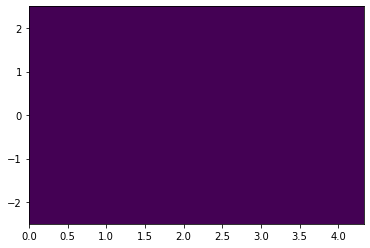

In [17]:
img = density_map(xs, ys, stats=False)

if nPosts == 2:
    x_peaks = np.where(img > peak_threshold)[1] * post0_x / nbins
    y_peaks = np.where(img > peak_threshold)[0] * (post0_y - post1_y) / nbins + post1_y
else:
    x_peaks = np.where(img > peak_threshold)[1] * post1_x / nbins
    y_peaks = np.where(img > peak_threshold)[0] * (post0_y - post2_y) / nbins + post2_y

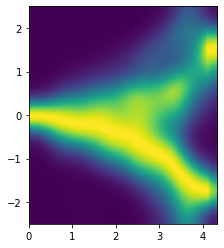

In [18]:
if nPosts == 2:
    plt.imshow(img ** 2, extent=[0, post0_x, post0_y, post1_y])
else:
    plt.imshow(img ** 2, extent=[0, post1_x, post0_y, post2_y])

In [24]:
tmax = df.loc[:,['uuid', 'nStimuli', 'event', 't']]
tmax = tmax.groupby(['uuid', 'nStimuli', 'event']).max().reset_index()
dmin = df.loc[:,['uuid', 'nStimuli', 'event', 't', 'dmin', 'post']]

dists = pd.merge(tmax, dmin, how='left')

In [25]:
d = dists[(dists['nStimuli'] > 0) & (dists['nStimuli'] < 4)]

In [27]:
if nPosts == 2:
    print(len(d[d['post'] == 0])/len(d), len(d[d['post'] == 1])/len(d))
else:
    print(len(d[d['post'] == 0])/len(d), len(d[d['post'] == 1])/len(d), len(d[d['post'] == 2])/len(d))

0.4575757575757576 0.5424242424242425
